In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import glob
import numpy as np
import pandas as pd
import fit_curve as fc

In [2]:
def transform_mesh_match(x):
    return x.replace(" ", "")

df_mesh = set(pd.read_csv("data/mtrees2015.bin", sep=";", header=None)[0].tolist())

In [3]:
mesh_correct = dict()
for m in df_mesh:
    mesh_correct[transform_mesh_match(m)] = m
    
mesh_correct_bc = sc.broadcast(mesh_correct)
print len(mesh_correct)

27453


## Generate data for calculating scores

In [4]:
def pmid_mesh(x, mesh_c=dict()):
    # Row to pmid year mesh
    x = x.split("\t")
    return (x[0], int(x[1]),
            tuple(set([mesh_c.get(transform_mesh_match(k), "__UNKNOWN__") for k in x[2].split('|')])))

def exploded_names(x):
    # Explode the mesh parents column into into list
    x = x.split('\t')
    return (x[0], tuple(x[1].split('|'))) # Return exploded mesh terms as tuple

mesh_exploded = sc.broadcast(sc.textFile("out/exploded_mhash.tsv").map(exploded_names).collectAsMap())
def get_exploded(k):
    # Get the parents of a mesh term.
    # If mesh is not in dict simply return the mesh
    try:
        return mesh_exploded.value[k]
    except:
        return (k,)


In [5]:
def get_exploded_counts(x):
    # Return list of exploded mesh year count tuples
    total_mesh = set(reduce(lambda a, b: a+b, map(get_exploded, x[2])))
    return (((k,x[1]),1) for k in total_mesh)

def get_exploded_pair_counts(x):
    # Return list of exploded mesh pair year count tuples
    total_mesh = set(reduce(lambda a, b: a+b, map(get_exploded, x[2])))
    total_mesh = sorted(total_mesh, key=lambda x: x.lower)
    mesh_pairs = [(k1,k2) for i,k1 in enumerate(total_mesh) for k2 in total_mesh[i+1:]]
    return (((k1,k2,x[1]),1) for k1,k2 in mesh_pairs)

# LOAD DATA FROM THE FILE
pmid_data = sc.textFile("data/pmid_year_mesh.noheader.tsv").map(lambda x: pmid_mesh(x, mesh_c=mesh_correct_bc.value))


In [23]:
# WRITE DATA FOR INDIVIDUAL MESH TERMS. ONLY EXPLODED COUNTS
mesh_exploded_year_count = pmid_data.flatMap(get_exploded_counts).reduceByKey(lambda x,y: x+y)
csv_data = mesh_exploded_year_count.map(lambda x: "%s\t%s\t%s" % (x[0][0], x[0][1], x[1]))
csv_data.saveAsTextFile("out/mesh_exploded_year")


In [24]:
# WRITE DATA FOR PAIRWISE MESH TERMS. ONLY EXPLODED COUNTS
meshpair_exploded_year_count = pmid_data.flatMap(get_exploded_pair_counts).reduceByKey(lambda x,y: x+y)
csv_data = meshpair_exploded_year_count.map(lambda x: "%s\t%s\t%s\t%s" % (x[0][0], x[0][1], x[0][2], x[1]))
csv_data.saveAsTextFile("out/meshpair_exploded_year")

# Individual Novelty Scores

In [6]:
pmid_per_year = pd.read_csv("out/PMID_PER_YEAR.tsv", sep="\t", index_col="year", dtype = {'Year':int, 'TotalPMID':float})
pmid_per_year_norm = pmid_per_year / pmid_per_year.TotalPMID.mean()

In [7]:
# CALCULATE MODEL AND EMPIRICAL SCORES FOR INDIVIDUAL MESH TERMS, ONLY EXPLODED COUNTS
def mesh_scores(x):
    year, counts = zip(*sorted(x, key=lambda k: k[0]))
    # Calculate Empirical scores
    
    #df = pd.DataFrame(data=list(counts), index=list(year), dtype=float)
    #df.columns = ["y"]
    # Collect all year and counts from spelling errors
    df = pd.DataFrame({"x": list(year), "y": list(counts)})
    df = df.groupby("x").sum()
    year, counts = df.index.values, df["y"].values

    # Start processing
    df["y"] = df["y"].astype("float")
    TFirstP = df.index - df.index.min()
    VolFirstP = df["y"].values.cumsum()
    # Calculate model scores
    #year_min, year_max = df.index.min() - 5, df.index.max() + 1
    popt, pcov = None, None
    for offset in [0,2,5,10]:
        #year_min, year_max = df.index.min()-offset, min(df.index.max() + 1, 2015)
        modified_min_year = max(df.index.min(), 1966)
        year_min, year_max = modified_min_year-offset, min(df.index.max() + 1, 2015)
        #print offset
        #year_range = np.arange(year_min, year_max)
        #year_range = range(year_min, df.index.min()) + df.index[df.index <= year_max].values.tolist()
        year_range = range(year_min, modified_min_year) + df.index[(df.index <= year_max) & (df.index>=modified_min_year)].values.tolist()
        df_y = pd.DataFrame(data=np.zeros_like(year_range), index=year_range, dtype=float)
        normalizer = pmid_per_year_norm.ix[df.index, "TotalPMID"]
        df_counts = np.log((df[df.index.isin(year_range)]["y"] / normalizer) + 1) # LOG shoud be base exp as per formula
        df_y["x"] = np.array(year_range) - year_min
        df_y["y"] = df_counts
        df_y["counts"] = df[df.index.isin(year_range)]["y"]
        df_y = df_y.fillna(0)
        x, y = df_y["x"], df_y["y"]
        # We now have x and y and we need to fit the curve.
        if df.shape[0] < 2:
            # Too few instances to fit
            #print "Too few instances"
            break
        if len(year_range) < 3:
            #print "Too small year range"
            continue
        try:
            #print df_y
            popt,pcov = fc.getFitCurve(x,y)
            #print popt
            if popt[0]*popt[2] > 0:
                break
        except RuntimeError:
            #print "Runtime error"
            popt, pcov = None, None
    # After fitting the curve we only need values for the original years
    #x_org = df_y.ix[df.index, "x"].values
    #predicted_val = fc.func(x_org, popt[0],popt[1],popt[2])
    #velocity = fc.f_der1(x_org, popt)
    df["x_fit"] = df.index - year_min
    if popt is not None and popt[0]*popt[2] > 0:
        #df["y_norm"] = np.log((df["y"] / normalizer) + 1) # LOG shoud be base exp as per formula
        x_inflex = int(popt[1] + year_min + 1)
        #print popt, x_inflex
        df["pred"] = fc.func(df["x_fit"], popt[0],popt[1],popt[2])
        df["pred_actual"] = (np.exp(df["pred"]) - 1) * normalizer
        df["velocity"] = fc.f_der1(df["x_fit"], popt)
        df["acceleration"] = fc.f_der2(df["x_fit"], popt)
        # Fill NAN Velocity values with 0
        df["velocity"] = df["velocity"].fillna(0)
        # Least precision of float in MySQL around 1e-20 and -1e-20
        df.ix[(df["x_fit"] <= x_inflex) & (df["acceleration"].isnull()), "acceleration"] = 0 # Fill positive acceleration
        df.ix[(df["x_fit"] > x_inflex) & (df["acceleration"].isnull()), "acceleration"] = -1e-20 # Fill negative acceleration
        df.ix[(df["acceleration"] == -0.0) & (df["x_fit"] > x_inflex), "acceleration"] = -1e-20 # Set all -0 values to -1e-20
        # Truncate all values less than 0 which have precision less than 1e-20 to -1e-20
        df.ix[(df["acceleration"] < 0) & (np.abs(df["acceleration"]) < 1e-20), "acceleration"] = -1e-20
    else:
        df["pred"] = np.nan
        df["pred_actual"] = np.nan
        df["velocity"] = np.nan
        df["acceleration"] = np.nan
    df = df.fillna("\\N")
    return ((year[i], counts[i], TFirstP[i], VolFirstP[i],\
        df["pred_actual"].values[i], df["velocity"].values[i], df["acceleration"].values[i]) for i in xrange(len(year)))



In [8]:
def read_mesh(x, mesh_c=dict()):
    x = x.split("\t")
    correct_mesh = mesh_c.get(transform_mesh_match(x[0]), "__UNKNOWN__")
    return (correct_mesh, int(x[1]), int(x[2]))


In [9]:
mesh_exploded_year_count = sc.textFile(",".join(glob.glob("out/mesh_exploded_year/part-*")))\
    .map(lambda x: read_mesh(x, mesh_c=mesh_correct_bc.value))
mesh_scores_data = mesh_exploded_year_count.map(lambda x: ((x[0]), (x[1], x[2]))).groupByKey().flatMapValues(mesh_scores)
csv_data = mesh_scores_data.map(lambda x: "%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s" \
    % (x[0], x[1][0], x[1][1], x[1][2], x[1][3], x[1][4], x[1][5], x[1][6]))
csv_data.saveAsTextFile("out/mesh_exploded_scores")


In [9]:
mesh_exploded_year_count = sc.textFile(",".join(glob.glob("out/mesh_exploded_year/part-*")))\
    .map(lambda x: read_mesh(x, mesh_c=mesh_correct_bc.value))

In [71]:
t = mesh_exploded_year_count.map(lambda x: ((x[0]), (x[1], x[2]))).filter(lambda x: x[0] == "Lactose Tolerance Test").groupByKey().collect()

In [72]:
tt = pd.DataFrame(list(mesh_scores(list(t[0][1]))))
tt

[  1.60844116   0.05634948  28.40997984] -0.00198343960915


,0,1,2,3,4,5,6,7
0,1967,1,0,1,0,1.000000,1.141488e+01,-9.134554e+00
1,1973,11,6,12,6,3.754980,4.032914e-73,-1.000000e-20
2,1974,24,7,36,7,3.820877,1.850638e-85,-1.000000e-20
3,1975,19,8,55,8,4.057935,8.492275e-98,-1.000000e-20
4,1976,17,9,72,9,4.142468,3.896965e-110,-1.000000e-20
5,1977,21,10,93,10,4.251472,1.788253e-122,-1.000000e-20
6,1978,19,11,112,11,4.414603,8.206002e-135,-1.000000e-20
7,1979,11,12,123,12,4.559864,3.765599e-147,-1.000000e-20
8,1980,22,13,145,13,4.530140,1.727972e-159,-1.000000e-20
9,1981,19,14,164,14,4.563006,7.929379e-172,-1.000000e-20


In [73]:
t = mesh_exploded_year_count.map(lambda x: ((x[0]), (x[1], x[2]))).filter(
    lambda x: x[0] == "Fluorescent Antibody Technique, Direct").groupByKey().collect()

In [74]:
tt = pd.DataFrame(list(mesh_scores(list(t[0][1]))))
tt

[   3.90247023 -524.76194476   18.73388139] 28.0113839713


,0,1,2,3,4,5,6,7
0,1966,1,0,1,0,0.000000,0.000000e+00,0.000000e+00
1,1970,2,4,3,4,0.000000,0.000000e+00,0.000000e+00
2,1976,1,10,4,10,0.000000,2.103602e-145,0.000000e+00
3,1977,2,11,6,11,0.000000,2.877298e-137,0.000000e+00
4,1980,1,14,7,14,0.000000,7.362898e-113,0.000000e+00
5,1983,1,17,8,17,0.000000,1.884138e-88,3.529722e-87
6,1984,1,18,9,18,0.000000,2.577116e-80,4.827939e-79
7,1989,1,23,10,23,0.000000,1.233788e-39,2.311364e-38
8,1994,8,28,18,28,8.000000,1.807085e+01,3.596302e+01
9,1995,113,29,131,29,84.095579,6.615555e-07,-1.239350e-05


In [32]:
all_data = sc.textFile(",".join(glob.glob("out/mesh_exploded_scores/part-*")))\
    .map(lambda x: x.split("\t")).map(lambda x: (x[0], int(x[2])))\
    .reduceByKey(lambda x, y: x+y).map(lambda x: x[1]).collect()

In [19]:
all_data = np.array(all_data)

(array([  194.,   786.,  2847.,  6018.,  7625.,  5794.,  2798.,   934.,
          222.,    32.]),
 array([ 0.        ,  0.72649239,  1.45298478,  2.17947716,  2.90596955,
         3.63246194,  4.35895433,  5.08544672,  5.81193911,  6.53843149,
         7.26492388]),
 <a list of 10 Patch objects>)

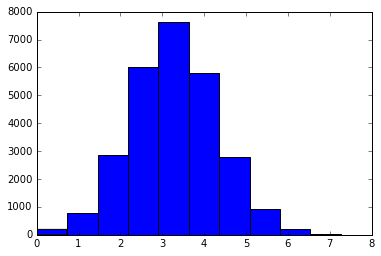

In [18]:
plt.hist(np.log10(all_data), bins=10)

In [22]:
np.sum(all_data < 100)

2842

# Pairwise novelty scores

In [25]:
def mesh_pair_scores(x):
    year, counts = zip(*sorted(x, key=lambda k: k[0]))
    df = pd.DataFrame({"x": list(year), "y": list(counts)})
    df = df.groupby("x").sum()
    year, counts = df.index.values, df["y"].values
    TFirstP = year - year.min()
    VolFirstP = counts.cumsum()
    return ((year[i], counts[i], TFirstP[i], VolFirstP[i]) for i in xrange(len(year)))


def read_mesh_pair(x, mesh_c=dict()):
    x = x.split("\t")
    correct_mesh1 = mesh_c.get(transform_mesh_match(x[0]), "__UNKNOWN__")
    correct_mesh2 = mesh_c.get(transform_mesh_match(x[1]), "__UNKNOWN__")
    return (correct_mesh1, correct_mesh2, int(x[2]), int(x[3]))


In [ ]:
meshpair_exploded_year_count = sc.textFile(",".join(glob.glob("out/meshpair_exploded_year/part-*")))\
    .map(lambda x: read_mesh_pair(x, mesh_c=mesh_correct_bc.value))

meshpair_scores_data = meshpair_exploded_year_count.map(lambda x: ((x[0], x[1]), (x[2], x[3]))).groupByKey()\
    .flatMapValues(mesh_pair_scores).filter(lambda x: (x[0][0] != "__UNKNOWN__") and (x[0][1] != "__UNKNOWN__"))

csv_data = meshpair_scores_data.map(lambda x: "%s\t%s\t%s\t%s\t%s\t%s" % (x[0][0], x[0][1], x[1][0], x[1][1], x[1][2], x[1][3]))
csv_data.saveAsTextFile("out/meshpair_exploded_scores")


## Generate novelty scores for all papers

Make sure all the data is filled in the database 
and the database connection properties are correctly set in `settings.json`

In [9]:
## LOAD THE score helpers module for connecting to the database. 
import score_helpers as sch

In [10]:
sch.gen_scores("111\t2000\tBreastNeoplasms", mesh_c=mesh_correct)

('111', '2000', 6377, 66, 99376.0, '\\N', '\\N', 0.021203, 0.021203)

In [11]:
sch.gen_pair_scores("111\t2000\tBreastNeoplasms", mesh_c=mesh_correct)

('111', '2000', '\\N', '\\N', '\\N')

In [ ]:
# RUN INDIVIDUAL SCORES
sc.textFile("data/pmid_year_mesh.noheader.tsv").map(lambda x: sch.gen_scores(x, mesh_c=mesh_correct_bc.value))\
    .filter(lambda x: x is not None).map(lambda x: "\t".join(["%s"]*len(x)) % x)\
    .saveAsTextFile("out/pmid_novelty_scores")

In [ ]:
# RUN PAIR SCORES
sc.textFile("data/pmid_year_mesh.noheader.tsv").map(lambda x: sch.gen_pair_scores(x, mesh_c=mesh_correct_bc.value))\
    .filter(lambda x: x is not None).map(lambda x: "\t".join(["%s"]*len(x)) % x)\
    .saveAsTextFile("out/pmid_novelty_pair_scores")

## Merge Scores

Merge individual and pairwise scores

In [13]:
individual_scores = sc.textFile("out/pmid_novelty_scores").map(lambda x: x.split()).map(lambda x: (int(x[0]), tuple(x)))
pair_scores = sc.textFile("out/pmid_novelty_pair_scores").map(lambda x: x.split()).map(lambda x: (int(x[0]), tuple(x[2:])))

In [14]:
individual_scores.leftOuterJoin(pair_scores).map(lambda x: x[1][0] + x[1][1])\
  .map(lambda x: "\t".join(["%s"]*len(x)) % x)\
  .saveAsTextFile("out/pmid_novelty_all_scores")

In [15]:
## Add mesh counts to the output

mesh_count = sc.textFile("data/pmid_year_mesh.noheader.tsv").map(
    lambda x: sch.get_mesh_counts(x, mesh_c=mesh_correct_bc.value, mesh_exp=mesh_exploded.value))
sc.textFile("out/pmid_novelty_all_scores").map(lambda x: x.split("\t"))\
    .map(lambda x: (int(x[0]), tuple(x))).leftOuterJoin(mesh_count)\
    .map(lambda x: x[1][0] + x[1][1])\
    .map(lambda x: "\t".join(["%s"]*len(x)) % x)\
    .saveAsTextFile("out/pmid_novelty_all_scores_mesh_c")